<center>
<h1>Energy Model Building Flow - Example 2</h1>
<h2>for platforms supporting system-level energy meters</h2>
</center>

This notebook shows how to build an energy model of a HiKey platform running an Android Linux kernel.

It can be used as a reference implementation of an energy model building flow for platforms<br>
where it's possible to measure the energy consumption at system level, that is either at battery<br>
level or as close as possible to the clusters.

In this case, it is not enough to isolate the CPUs of the target cluster, but we also have to make<br>
sure that all tasks (except the essential ones) are **frozen** to avoid affecting battery power<br>
measurements. This will be achieved by exploiting the cgroup `freezer` controller.

### Note: this requires `scipy`

You can install it with `sudo -H pip install scipy` or similar.

# Configuration

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

In [2]:
%matplotlib inline

import devlib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import trappy

from collections import namedtuple, OrderedDict
from csv import DictWriter
from env import TestEnv
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from scipy.stats import linregress
from time import sleep
from trappy.plotter.ColorMap import ColorMap

# Support for trace events analysis
from trace import Trace
# Import support for Android devices
from android import Screen, Workload, System

In [15]:
# Setup a target configuration
my_conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'hikey',

    "results_dir" : "EnergyModel_SystemEnergy",

    # Energy Meters Configuration for BayLibre's ACME Cape
    "emeter" : {
        "instrument" : "aep",
        "conf" : {
            'resistor_values' : [0.099],
            'device_entry'    : '/dev/ttyACM0'
        },
        "channel_map" : {
            "Device0" : "BAT"
        }
    },

    # Tools required by the experiments
    "tools"   : ['trace-cmd', 'sysbench'],
    "modules" : ['cpufreq', 'cpuidle', 'hotplug', 'cgroups'],
    
    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "cpu_frequency",
            "cpu_idle",
            "sched_switch"
         ],
         "buffsize" : 10 * 1024,
    },
}

In [4]:
!adb root

adbd is already running as root


In [10]:
# Initialize a test environment using:
# the provided target configuration (my_conf)
te = TestEnv(target_conf=my_conf, force_new=True)
target = te.target

2016-09-09 14:03:28,185 INFO    :         Target - Using base path: /data/lisa
2016-09-09 14:03:28,186 INFO    :         Target - Loading custom (inline) target configuration
2016-09-09 14:03:28,189 INFO    :         Target - Devlib modules to load: ['cpuidle', 'cpufreq', 'cgroups', 'hotplug']
2016-09-09 14:03:28,190 INFO    :         Target - Connecting Android target [DEFAULT]
2016-09-09 14:03:28,191 INFO    :         Target - Connection settings:
2016-09-09 14:03:28,192 INFO    :         Target -    None
2016-09-09 14:03:28,676 INFO    :         Target - Initializing target workdir:
2016-09-09 14:03:28,677 INFO    :         Target -    /data/local/tmp/devlib-target
2016-09-09 14:03:32,960 INFO    :         Target - Topology:
2016-09-09 14:03:32,961 INFO    :         Target -    [[0, 1, 2, 3, 4, 5, 6, 7]]
2016-09-09 14:03:33,356 INFO    :         FTrace - Enabled tracepoints:
2016-09-09 14:03:33,357 INFO    :         FTrace -   cpu_frequency
2016-09-09 14:03:33,358 INFO    :         

## Critical tasks declaration

Energy measured of a cluster at system-level is affected by noise due the other clusters running in the system. To limit effect of this noise we exploit the `freezer cpuset` controller to freeze the tasks already running in the system. However, we need to be careful not to freeze those tasks that allow us to communicate with the target.

Hence, we define here-below a list of tasks called *CRITICAL* that must not be frozen.

In [7]:
# Lists of critical tasks for each platform
CRITICAL_TASKS = {
    'linux': ["init", "sh"],
    'android': ["/system/bin/sh", "adbd", "/init"]
    }

## Energy Model Parameters (CPUs, OPPs and Idle States)

In [10]:
# The EM reports capacity and energy consumption for each frequency domain.
# The frequency domains to be considered by the following EM building flow
# are described by the parameters of this named tuple
ClusterDescription = namedtuple('ClusterDescription',
                                ['name', 'emeter_ch', 'core_name',
                                 'cpus', 'freqs', 'idle_states'])

Being Hikey a SMP platform we can limit the scope of the experiment to one cluster only and then replicate the code by hand.

In [11]:
clusters = [
    ClusterDescription(
        # Name of the cluster
        name = "PD_0",
        # Name of the energy meter channel as specified in the target configuration
        emeter_ch = "Device0",
        # Name of the cores in the cluster
        core_name = "A53_PD_0",
        # List of cores in the cluster
        cpus = [0, 1, 2, 3],
        # List of frequencies available in the cluster
        freqs = [208000, 432000, 729000, 960000, 1200000],
        # List of idle states available in the cluster
        idle_states = range(len(target.cpuidle.get_states()))
    ),
#     ClusterDescription("PD_1",
#                        "Device0",
#                        "A53_PD_1",
#                        [4, 5, 6, 7],
#                        [208000, 432000, 729000, 960000, 1200000],
#                        range(len(target.cpuidle.get_states()))
#     )
]

In [12]:
clusters

[ClusterDescription(name='PD_0', emeter_ch='Device0', core_name='A53_PD_0', cpus=[0, 1, 2, 3], freqs=[208000, 432000, 729000, 960000, 1200000], idle_states=[0, 1, 2])]

In [13]:
# Mapping between cluster names and cluster IDs
cluster_ids = OrderedDict([
        (0, 'PD_0'),
#         (1, 'PD_1')
    ])

## Benchmark example

In [14]:
class Sysbench(object):
    """
    Sysbench benchmark class.
    
    :param duration: maximum workload duration in seconds
    :type duration: int
    """
    sysbench_path = "/data/local/tmp/bin/sysbench"
    
    def __init__(self, target, duration):
        self.target = target
        self.duration = duration

    def run(self, cgroup, threads):
        """
        Run benchmark using the specified number of 'threads'
        to be executed under the specified 'cgroup'.
        
        :param cgroup: cgroup where to run the benchmark on
        :type cgroup: str
        
        :param threads: number of threads to spawn
        :type threads: int
        
        :returns: float - performance score
        """
        bench_out = self.target.cgroups.run_into(
            cgroup,
            "{} --test=cpu --num-threads={} --max-time={} run"
            .format(self.sysbench_path, threads, self.duration)
        )
        match = re.search(r'(total number of events:\s*)([\d.]*)', bench_out)
        return float(match.group(2))

# Utility Functions

In [135]:
def linfit(x, y):
    slope, intercept, r, p, stderr = linregress(x, y)
    return slope, intercept

# Energy Model Building

## Active States Profiling

In [17]:
def compute_power_perf(clusters, loop_cnt, benchmark, bkp_file='pstates.csv'):
    """
    Perform P-States profiling on each input cluster.
    
    This method requires a `benchmark` object with the following
    characteristics:
        
        - duration, attribute that tells the workload duration in seconds
        - run(cgroup, threads), run the benchmark into the specified 'cgroup',
                                spawning the specified number of 'threads',
                                and return a performance score of their execution.
                                
    Data will be saved into a CSV file at each iteration such that, if something
    goes wrong, the user can restart the experiment considering only idle_states
    that had not yet been profiled.
    
    :param clusters: list of clusters to profile
    :type clusters: list(namedtuple(ClusterDescription))
    
    :param loop_cnt: number of iterations for each experiment
    :type loop_cnt: int
    
    :param benchmark: benchmark object
    :type benchmark: int
    
    :param bkp_file: CSV file name
    :type bkp_file: str
    """

    # Make sure all CPUs are online
    target.hotplug.online_all()

    # Set cpufreq governor to userpace to allow manual frequency scaling
    target.cpufreq.set_all_governors('userspace')
    
    with open(bkp_file, 'w') as csvfile:
        writer = DictWriter(csvfile,
                            fieldnames=['cluster', 'cpus', 'freq',
                                        'perf', 'energy', 'power'])

        # Freeze all userspace tasks
        target.cgroups.freeze(exclude=CRITICAL_TASKS['android'])

        # A) For each cluster (i.e. frequency domain) to profile...
        power_perf = []
        for cl in clusters:
            target_cg, _ = target.cgroups.isolate(cl.cpus)

            # P-States profiling requires to plug in CPUs one at the time
            for cpu in cl.cpus:
                target.hotplug.offline(cpu)

            # B) For each additional cluster's plugged in CPU...
            on_cpus = []
            for cnt, cpu in enumerate(cl.cpus):
                
                # Hotplug ON one more CPU
                target.hotplug.online(cpu)
                on_cpus.append(cpu)
                
                # Ensure online CPUs are part of the target cgroup
                # (in case hotplug OFF removes it)
                target_cg.set(cpus=on_cpus)
                cl_cpus = set(target.list_online_cpus()).intersection(set(cl.cpus))
                logging.info('Cluster {:8} (Online CPUs : {})'\
                              .format(cl.name, list(cl_cpus)))

                # C) For each OPP supported by the current cluster
                for freq in cl.freqs:

                    # Set frequency to freq for current CPU
                    target.cpufreq.set_frequency(cpu, freq)

                    # Run the benchmark for the specified number of iterations each time
                    # collecting a sample of energy consumption and reported performance
                    energy = 0.0
                    perf = 0.0
                    for i in xrange(loop_cnt):
                        te.emeter.reset()
                        # Run benchmark into the LISA_EM_TARGET cgroup
                        perf += benchmark.run(target_cg.name, cnt + 1)
                        nrg = te.emeter.report(te.res_dir).channels
                        energy += float(nrg[cl.emeter_ch])
                        sleep(1)

                    # Compute average energy and performance for the current number of
                    # active CPUs all running at the current OPP
                    perf = perf / loop_cnt
                    energy = energy / loop_cnt
                    power = energy / benchmark.duration

                    # Keep track of this new P-State profiling point
                    new_row = {'cluster': cl.name,
                               'cpus': cnt + 1,
                               'freq': freq,
                               'perf': perf,
                               'energy' : energy,
                               'power': power}
                    power_perf.append(new_row)

                    # Save data in a CSV file
                    writer.writerow(new_row)
                    
                # C) profile next P-State

            # B) add one more CPU (for the current frequency domain)

        # A) Profile next cluster (i.e. frequency domain)
                    
        # Thaw all frozen tasks
        target.cgroups.freeze(thaw=True)

        target.hotplug.online_all()

        power_perf_df = pd.DataFrame(power_perf)
    return power_perf_df.set_index(['cluster', 'freq', 'cpus']).sort_index(level='cluster')

In [19]:
sysbench = Sysbench(target, 10)
loop_cnt = 5

power_perf_df = compute_power_perf(clusters, loop_cnt, sysbench)

2016-09-09 14:08:59,775 INFO    : Cluster PD_0 - Online CPUs : set([0])
2016-09-09 14:14:05,620 INFO    : Cluster PD_0 - Online CPUs : set([0, 1])
2016-09-09 14:19:10,296 INFO    : Cluster PD_0 - Online CPUs : set([0, 1, 2])
2016-09-09 14:24:14,730 INFO    : Cluster PD_0 - Online CPUs : set([0, 1, 2, 3])


In [20]:
def plot_pstates(power_perf_df, cluster):
    """
    Plot P-States profiling for the specified cluster.
    
    :param power_perf_df: DataFrame reporting power and performance values
    :type power_perf_df: :mod:`pandas.DataFrame`
    
    :param cluster: cluster description
    :type cluster: namedtuple(ClusterDescription)
    """
    cmap = ColorMap(len(cluster.freqs))
    color_map = map(cmap.cmap, range(len(cluster.freqs)))
    color_map = dict(zip(cluster.freqs, color_map))
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    
    grouped = power_perf_df.loc[cluster.name].groupby(level='freq')
    for freq, df in grouped:
        x = df.index.get_level_values('cpus').tolist()
        y = df.power.tolist()
        slope, intercept = linfit(x, y)
        x.insert(0, 0)
        y.insert(0, intercept)
        # Plot linear fit of the points
        ax.plot(x, [slope*i + intercept for i in x], color=color_map[freq])
        # Plot measured points
        ax.scatter(x, y, color=color_map[freq], label='{} kHz'.format(freq))

    ax.set_title('HiKey {} cluster P-States profiling'.format(cluster.name),
                 fontsize=16)
    ax.legend()
    ax.set_xlabel('Active cores')
    ax.set_ylabel('Power [$\mu$W]')
    ax.set_xlim(-0.5, len(cluster.cpus)+1)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.grid(True)

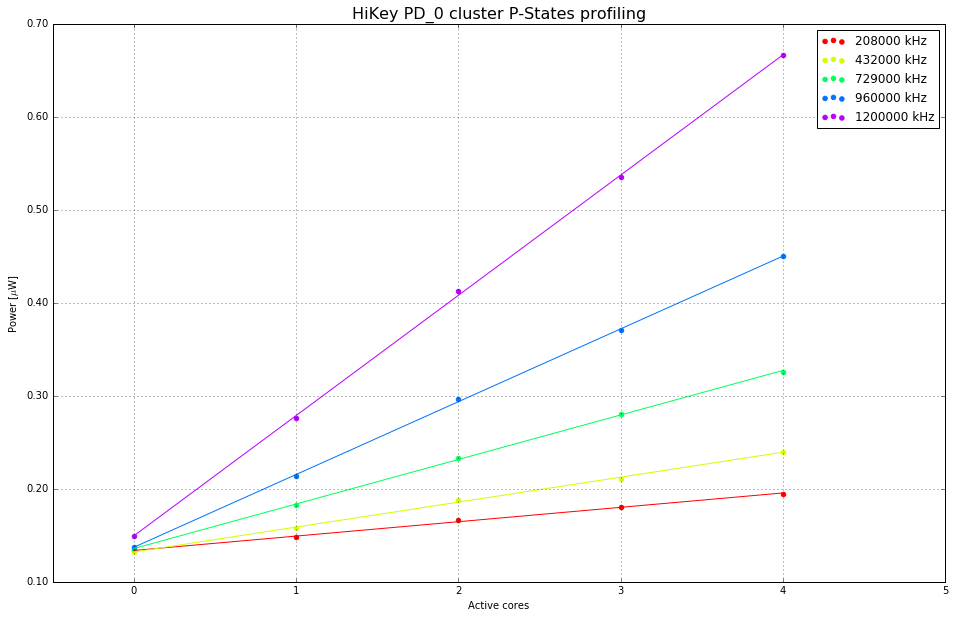

In [21]:
pd0_cl = clusters[0]

plot_pstates(power_perf_df, pd0_cl)

### Statistics

In [23]:
def power_perf_stats(power_perf_df):
    """
    For each cluster compute per-OPP power and performance statistics.
    
    :param power_perf_df: dataframe containing power and performance numbers
    :type power_perf_df: :mod:`pandas.DataFrame`
    """
    clusters = power_perf_df.index.get_level_values('cluster')\
                                  .unique().tolist()

    stats = []   
    for cl in clusters:
        cl_power_df = power_perf_df.loc[cl].reset_index()

        grouped = cl_power_df.groupby('freq')
        for freq, df in grouped:
            perf = df['perf'] / df['cpus']
            power = df['power'] / df['cpus']
            energy = df['energy'] / df['cpus']

            avg_row = {'cluster': cl,
                       'freq': freq,
                       'stats': 'avg',
                       'perf': perf.mean(),
                       'power': power.mean(),
                       'energy': energy.mean()
                      }
            std_row = {'cluster': cl,
                       'freq': freq,
                       'stats': 'std',
                       'perf': perf.std(),
                       'power': power.std(),
                       'energy': energy.std()
                      }
            min_row = {'cluster': cl,
                       'freq': freq,
                       'stats': 'min',
                       'perf': perf.min(),
                       'power': power.min(),
                       'energy': energy.min()
                      }
            max_row = {'cluster' : cl,
                       'freq' : freq,
                       'stats' : 'max',
                       'perf' : perf.max(),
                       'power' : power.max(),
                       'energy': energy.max()
                      }
            c99_row = {'cluster' : cl,
                       'freq' : freq,
                       'stats' : 'c99',
                       'perf' : perf.quantile(q=0.99),
                       'power' : power.quantile(q=0.99),
                       'energy': energy.quantile(q=0.99)
                      }

            stats.append(avg_row)
            stats.append(std_row)
            stats.append(min_row)
            stats.append(max_row)
            stats.append(c99_row)
    
    stats_df = pd.DataFrame(stats).set_index(['cluster', 'freq', 'stats'])\
                                  .sort_index(level='cluster')
    return stats_df.unstack()

In [24]:
pp_stats = power_perf_stats(power_perf_df)

### Plots

In [25]:
def plot_power_perf(pp_stats, clusters):
    cmap = ColorMap(len(clusters) + 1)
    color_map = map(cmap.cmap, range(len(clusters) + 1))
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))

    max_perf = pp_stats.perf['avg'].max()
    max_power = pp_stats.power['avg'].max()

    for i, cl in enumerate(clusters):
        cl_df = pp_stats.loc[cl.name]
        norm_perf_df = cl_df.perf['avg'] * 100.0 / max_perf
        norm_power_df = cl_df.power['avg'] * 100.0 / max_power

        x = norm_perf_df.values.tolist()
        y = norm_power_df.values.tolist()
        ax.plot(x, y, color=color_map[i], marker='o', label=cl.name)

        norm_perf_df = cl_df.perf['max'] * 100.0 / max_perf
        norm_power_df = cl_df.power['max'] * 100.0 / max_power

        x = norm_perf_df.values.tolist()
        y = norm_power_df.values.tolist()
        ax.plot(x, y, '--', color=color_map[-1])

        norm_perf_df = cl_df.perf['min'] * 100.0 / max_perf
        norm_power_df = cl_df.power['min'] * 100.0 / max_power

        x = norm_perf_df.values.tolist()
        y = norm_power_df.values.tolist()
        ax.plot(x, y, '--', color=color_map[-1])

    ax.set_title('HyKey Power VS Performance curves', fontsize=16)
    ax.legend()
    ax.set_xlabel('Performance [%]')
    ax.set_ylabel('Power [%]')
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 120)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(True)

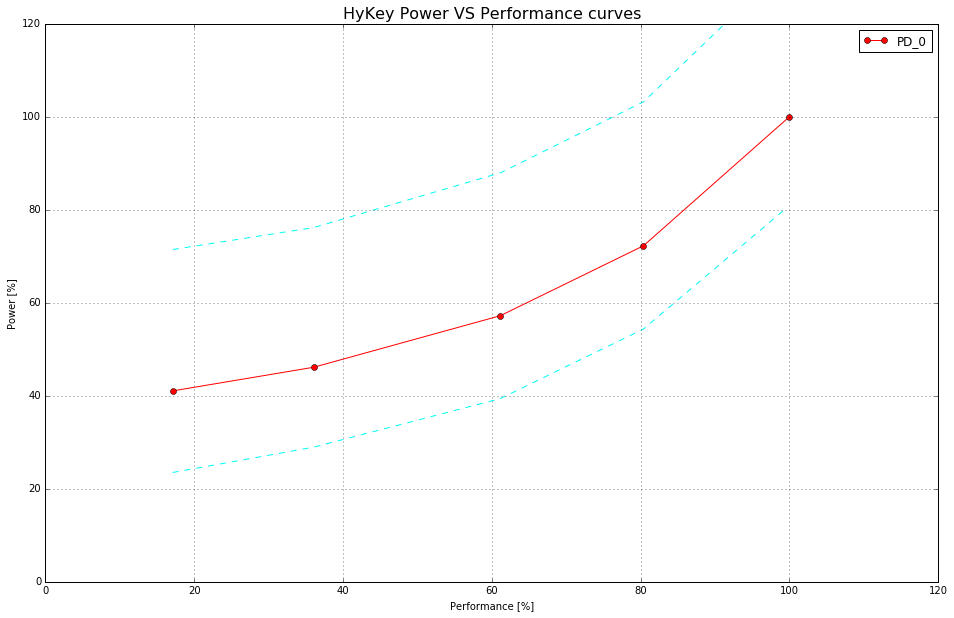

In [26]:
plot_power_perf(pp_stats, clusters)

## Idle States Profiling

In [30]:
def compute_idle_power(clusters, loop_cnt, sleep_duration, bkp_file='cstates.csv'):
    """
    Perform C-States profiling on each input cluster.
    
    Data will be saved into a CSV file at each iteration such that if something
    goes wrong the user can restart the experiment considering only idle_states
    that had not been processed.
    
    :param clusters: list of clusters to profile
    :type clusters: list(namedtuple(ClusterDescription))
    
    :param loop_cnt: number of loops for each experiment
    :type loop_cnt: int
    
    :param sleep_duration: sleep time in seconds
    :type sleep_duration: int
    
    :param bkp_file: CSV file name
    :type bkp_file: str
    """

    # Make sure all CPUs are online
    target.hotplug.online_all()

    with open(bkp_file, 'w') as csvfile:
        writer = DictWriter(csvfile, fieldnames=['cluster', 'cpus',
                                                 'idle_state', 'energy', 'power'])

        # Disable frequency scaling by setting cpufreq governor to userspace
        target.cpufreq.set_all_governors('userspace')

        # Freeze all tasks but the ones to communicate with the target
        target.cgroups.freeze(exclude=CRITICAL_TASKS['android'])

        all_cpus = set(range(target.number_of_cpus))
        idle_power = []
        for cl in clusters:

            # In current cluster, hotplug OFF all CPUs but the first one
            # At least one CPU must be online
            target.hotplug.online(cl.cpus[0])
            for cpu in cl.cpus[1:]:
                target.hotplug.offline(cpu)

            other_cpus = list(all_cpus - set(cl.cpus))
            # CPUs in the other clusters will be kept hotplugged OFF
            # to not affect measurements on the current cluster
            for cpu in other_cpus:
                target.hotplug.offline(cpu)

            # B) For each additional cluster's plugged in CPU...
            for cnt, cpu in enumerate(cl.cpus):
                
                # Hotplug ON one more CPU
                target.hotplug.online(cpu)
                
                cl_cpus = set(target.list_online_cpus()).intersection(set(cl.cpus))
                logging.info('Cluster {:8} (Online CPUs : {})'\
                              .format(cl.name, list(cl_cpus)))

                for idle in cl.idle_states:

                    # Disable all idle states but the current one
                    for c in cl.cpus:
                        target.cpuidle.disable_all(cpu=c)
                        target.cpuidle.enable(idle, cpu=c)

                    sleep(3)
                    # Sleep for the specified duration each time collecting a sample
                    # of energy consumption and reported performance
                    energy = 0.0
                    for i in xrange(loop_cnt):
                        te.emeter.reset()
                        sleep(sleep_duration)
                        nrg = te.emeter.report(te.res_dir).channels
                        energy += float(nrg[cl.emeter_ch])

                    # Compute average energy and performance for the current number of
                    # active CPUs all idle at the current OPP
                    energy = energy / loop_cnt
                    power = energy / SLEEP_DURATION

                    # Keep track of this new C-State profiling point
                    new_row = {'cluster': cl.name,
                               'cpus': cnt + 1,
                               'idle_state': idle,
                               'energy': energy,
                               'power': power}
                    idle_power.append(new_row)

                    # Save data in a CSV file
                    writer.writerow(new_row)
                    
                # C) profile next C-State

            # B) add one more CPU (for the current frequency domain)

        # A) profile next cluster (i.e. frequency domain)

        # Thaw all tasks in the freezer cgroup
        target.cgroups.freeze(thaw=True)
        target.hotplug.online_all()

        idle_df = pd.DataFrame(idle_power)
    return idle_df.set_index(['cluster', 'idle_state', 'cpus']).sort_index(level='cluster')

In [37]:
SLEEP_DURATION = 10
loop_cnt = 5

idle_df = compute_idle_power(clusters, loop_cnt, SLEEP_DURATION)

2016-09-09 14:52:14,747 INFO    : Cluster PD_0 - Online CPUs : set([0])
2016-09-09 14:55:11,721 INFO    : Cluster PD_0 - Online CPUs : set([0, 1])
2016-09-09 14:58:08,616 INFO    : Cluster PD_0 - Online CPUs : set([0, 1, 2])
2016-09-09 15:01:05,259 INFO    : Cluster PD_0 - Online CPUs : set([0, 1, 2, 3])


In [41]:
idle_df

energy     power
cluster idle_state cpus                    
PD_0    0          1     1.615466  0.161547
                   2     1.660321  0.166032
                   3     1.721711  0.172171
                   4     1.774200  0.177420
        1          1     1.551541  0.155154
                   2     1.549942  0.154994
                   3     1.557366  0.155737
                   4     1.561172  0.156117
        2          1     1.256227  0.125623
                   2     1.608698  0.160870
                   3     1.257657  0.125766
                   4     1.260770  0.126077

### Idle Power Statistics

In [42]:
WFI = 0
CORE_OFF = 1

def idle_power_stats(idle_df):
    """
    For each cluster compute per idle state power statistics.
    
    :param idle_df: dataframe containing power numbers
    :type idle_df: :mod:`pandas.DataFrame`
    """

    stats = []
    for cl in clusters:
        cl_df = idle_df.loc[cl.name].reset_index()
        # Start from deepest idle state
        cl_df = cl_df.sort_values('idle_state', ascending=False)
        grouped = cl_df.groupby('idle_state', sort=False)
        for state, df in grouped:
            energy = df.energy
            power = df.power
            state_name = "C{}_CLUSTER".format(state)
            if state == CORE_OFF:
                core_off_nrg_avg = energy.mean()
                core_off_pwr_avg = power.mean()
            if state == WFI:
                energy = df.energy.diff()
                energy[0] = df.energy[0] - core_off_nrg_avg
                power = df.power.diff()
                power[0] = df.power[0] - core_off_pwr_avg
                state_name = "C0_CORE"

            avg_row = {'cluster': cl.name,
                       'idle_state': state_name,
                       'stats': 'avg',
                       'energy': energy.mean(),
                       'power': power.mean()
                      }
            std_row = {'cluster': cl.name,
                       'idle_state': state_name,
                       'stats': 'std',
                       'energy': energy.std(),
                       'power': power.std()
                      }
            min_row = {'cluster' : cl.name,
                       'idle_state' : state_name,
                       'stats' : 'min',
                       'energy' : energy.min(),
                       'power' : power.min()
                      }
            max_row = {'cluster' : cl.name,
                       'idle_state' : state_name,
                       'stats' : 'max',
                       'energy' : energy.max(),
                       'power' : power.max()
                      }
            c99_row = {'cluster' : cl.name,
                       'idle_state' : state_name,
                       'stats' : 'c99',
                       'energy' : energy.quantile(q=0.99),
                       'power' : power.quantile(q=0.99)
                      }
            stats.append(avg_row)
            stats.append(std_row)
            stats.append(min_row)
            stats.append(max_row)
            stats.append(c99_row)
    
    stats_df = pd.DataFrame(stats).set_index(
        ['cluster', 'idle_state', 'stats']).sort_index(level='cluster')
    return stats_df.unstack()

In [103]:
idle_stats = idle_power_stats(idle_df)

### Plotting Idle power

In [44]:
def plot_cstates(idle_power_df, cluster):
    """
    Plot C-States profiling for the specified cluster.
    
    :param idle_power_df: dataframe reporting power values in each idle state
    :type idle_power_df: :mod:`pandas.DataFrame`

    :param cluster: cluster description
    :type cluster: namedtuple(ClusterDescription)
    """
    n_cpus = len(cluster.cpus)
    cmap = ColorMap(len(cluster.idle_states))
    color_map = map(cmap.cmap, cluster.idle_states)
    color_map = [c for c in color_map for i in xrange(n_cpus)]

    cl_df = idle_power_df.loc[cluster.name]
    ax = cl_df.power.plot.bar(figsize=(16,8), color=color_map, alpha=0.5,
                              legend=False, table=True)

    idx = 0
    grouped = cl_df.groupby(level=0)
    for state, df in grouped:
        x = df.index.get_level_values('cpus').tolist()
        y = df.power.tolist()
        slope, intercept = linfit(x, y)

        y = [slope * v + intercept for v in x]
        x = range(n_cpus * idx, n_cpus * (idx + 1))
        ax.plot(x, y, color=color_map[idx*n_cpus], linewidth=4)
        idx += 1

    ax.grid(True)
    ax.get_xaxis().set_visible(False)
    ax.set_ylabel("Idle Power [$\mu$W]")
    ax.set_title("{} cluster C-states profiling"\
                 .format(cluster.name), fontsize=16)

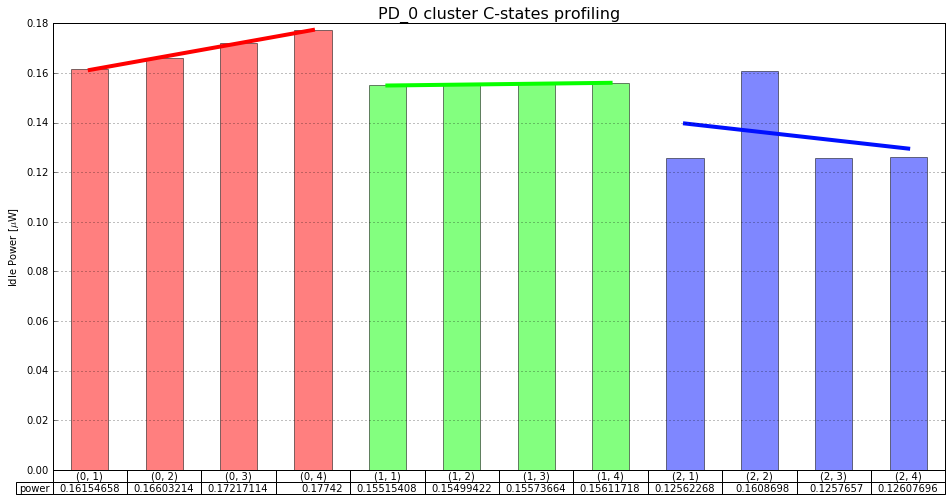

In [45]:
pd0 = clusters[0]

plot_cstates(idle_df, pd0)

# Energy Model Generation

In [123]:
def pstates_model_df(clusters, pp_stats, power_perf_df, metric='avg'):
    """
    Build two data frames containing data to create the energy model for each
    cluster given as input.
    
    :param clusters: list of clusters to profile
    :type clusters: list(namedtuple(ClusterDescription))
    
    :param pp_stats: power and performance statistics
    :type pp_stats: :mod:`pandas.DataFrame`
    
    :param power_perf_df: power and performance data
    :type power_perf_df: :mod:`pandas.DataFrame`
    """
    max_score = pp_stats.perf[metric].max()

    core_cap_energy = []
    cluster_cap_energy = []
    for cl in clusters:
        # ACTIVE Energy
        grouped = power_perf_df.loc[cl.name].groupby(level='freq')
        for freq, df in grouped:
            # Get average energy at OPP freq for 1 CPU
            energy_freq_1 = pp_stats.loc[cl.name].loc[freq]['energy'][metric]
            # Get cluster energy at OPP freq
            x = df.index.get_level_values('cpus').tolist()
            y = df.energy.tolist()
            slope, intercept = linfit(x, y)
            # Energy can't be negative but the regression line may intercept the
            # y-axis at a negative value. Im this case cluster energy can be
            # assumed to be 0.
            cluster_energy = intercept if intercept >= 0.0 else 0.0
            core_energy = energy_freq_1 - cluster_energy
            #core_energy = cluster_energy

            # Get score at OPP freq
            score_freq = pp_stats.loc[cl.name].loc[freq]['perf'][metric]
            capacity = int(score_freq * 1024 / max_score)

            core_cap_energy.append({'cluster' : cl.name,
                                    'core': cl.core_name,
                                    'freq': freq,
                                    'cap': capacity,
                                    'energy': core_energy})
            cluster_cap_energy.append({'cluster': cl.name,
                                       'freq': freq,
                                       'cap': capacity,
                                       'energy': cluster_energy})

    core_cap_nrg_df = pd.DataFrame(core_cap_energy)
    cluster_cap_nrg_df = pd.DataFrame(cluster_cap_energy)
    return core_cap_nrg_df, cluster_cap_nrg_df

In [125]:
core_cap_nrg_df, cluster_cap_nrg_df = pstates_model_df(clusters,
                                                       pp_stats,
                                                       power_perf_df,
                                                       metric='avg'
                                                      )

In [126]:
core_cap_nrg_df

,cap,cluster,core,energy,freq
0,175,PD_0,A53_PD_0,-0.487181,208000
1,369,PD_0,A53_PD_0,-0.364934,432000
2,626,PD_0,A53_PD_0,-0.173280,729000
3,823,PD_0,A53_PD_0,0.124791,960000
4,1024,PD_0,A53_PD_0,0.575753,1200000


In this case, taking the average energy consumed by a core does not provide a nice result because the energy measured while running with $n$ CPUs **is not** $n \times Energy\_of\_one\_CPU$.

For this reason, we will use a different metric, like for instance the 99th percentile.

In [127]:
core_cap_nrg_df, cluster_cap_nrg_df = pstates_model_df(clusters,
                                                       pp_stats,
                                                       power_perf_df,
                                                       metric='c99'
                                                      )

In [128]:
core_cap_nrg_df

,cap,cluster,core,energy,freq
0,175,PD_0,A53_PD_0,0.122582,208000
1,369,PD_0,A53_PD_0,0.237698,432000
2,625,PD_0,A53_PD_0,0.443248,729000
3,822,PD_0,A53_PD_0,0.746307,960000
4,1024,PD_0,A53_PD_0,1.250150,1200000


In [129]:
cluster_cap_nrg_df

,cap,cluster,energy,freq
0,175,PD_0,1.336880,208000
1,369,PD_0,1.319919,432000
2,625,PD_0,1.357663,729000
3,822,PD_0,1.370620,960000
4,1024,PD_0,1.493721,1200000


In [130]:
def energy_model_dict(clusters, core_cap_nrg_df, cluster_cap_nrg_df, metric='avg'):
    n_states = len(clusters[0].idle_states)

    nrg_dict = {}

    grouped = core_cap_nrg_df.groupby('cluster')
    for cl, df in grouped:
        nrg_dict[cl] = {
            "opps" : {},
            "core": {
                "name": df.core.iloc[0],
                "busy-cost": OrderedDict(),
                "idle-cost": OrderedDict()
            },
            "cluster": {
                "busy-cost": OrderedDict(),
                "idle-cost": OrderedDict()
            }
        }
        # Core COSTS
        # ACTIVE costs
        for row in df.iterrows():
            nrg_dict[cl]["opps"][row[1].cap] = row[1].freq
            nrg_dict[cl]["core"]["busy-cost"][row[1].cap] = int(row[1].energy*100)

        # IDLE costs
        wfi_nrg = idle_stats.loc[cl].energy[metric][0]
        # WFI
        nrg_dict[cl]["core"]["idle-cost"][0] = int(wfi_nrg*100)
        # All remaining states are zeroes
        for i in xrange(1, n_states):
            nrg_dict[cl]["core"]["idle-cost"][i] = 0

        # Cluster COSTS
        cl_data = cluster_cap_nrg_df[cluster_cap_nrg_df.cluster == cl]
        # ACTIVE costs
        for row in cl_data.iterrows():
            nrg_dict[cl]["cluster"]["busy-cost"][row[1].cap] = int(row[1].energy*100)

        # IDLE costs
        # Core OFF is the first valid idle cost for cluster
        idle_data = idle_stats.loc[cl].energy[metric]
        # WFI (same as Core OFF)
        nrg_dict[cl]["cluster"]["idle-cost"][0] = int(idle_data[1]*100)
        # All other idle states (from CORE OFF down)
        for i in xrange(1, n_states):
            nrg_dict[cl]["cluster"]["idle-cost"][i] = int(idle_data[i]*100)

    return nrg_dict

In [131]:
nrg_dict = energy_model_dict(clusters, core_cap_nrg_df, cluster_cap_nrg_df)

## Device Tree EM Format

In [70]:
def dump_device_tree(nrg_dict, outfile='sched-energy.dtsi'):
    """
    Generate device tree energy model file.
    
    :param nrg_dict: dictionary describing the energy model
    :type nrg_dict: dict
    
    :param outfile: output file name
    :type outfile: str
    """
    with open(os.path.join(te.res_dir, outfile), 'w') as out:
        out.write("energy-costs {\n")
        idx = 0
        for cl_name in nrg_dict.keys():
            core = nrg_dict[cl_name]["core"]
            # Dump Core costs
            out.write("\tCPU_COST_{}: core_cost{} {}\n"\
                      .format(core["name"], idx, '{'))
            # ACTIVE costs
            out.write("\t\tbusy-cost-data = <\n")
            for cap, nrg in core["busy-cost"].iteritems():
                out.write("\t\t\t{} {}\n".format(cap, nrg))
            out.write("\t\t>;\n")
            # IDLE costs
            out.write("\t\tidle-cost-data = <\n")
            # arch idle
            out.write("\t\t\t{}\n".format(core["idle-cost"][0]))
            for nrg in core["idle-cost"].values():
                out.write("\t\t\t{}\n".format(nrg)) 
            out.write("\t\t>;\n")
            out.write("\t};\n")

            # Dump Cluster costs
            cl = nrg_dict[cl_name]["cluster"]
            out.write("\tCLUSTER_COST_{}: cluster_cost{} {}\n"\
                      .format(cl_name, idx, '{'))
            # ACTIVE costs
            out.write("\t\tbusy-cost-data = <\n")
            for cap, nrg in cl["busy-cost"].iteritems():
                out.write("\t\t\t{} {}\n".format(cap, nrg))
            out.write("\t\t>;\n")
            # IDLE costs
            out.write("\t\tidle-cost-data = <\n")
            # arch idle
            out.write("\t\t\t{}\n".format(cl["idle-cost"][0]))
            for nrg in cl["idle-cost"].values():
                out.write("\t\t\t{}\n".format(nrg))
            out.write("\t\t>;\n")
            out.write("\t};\n")
            idx += 1
        out.write("};")

## C Code EM Format

In [71]:
def dump_c_code(nrg_dict, cluster_ids, outfile='energy_model.c'):
    """
    Generate C code energy model file.
    
    :param nrg_dict: dictionary describing the energy model
    :type nrg_dict: dict
    
    :param cluster_ids: mapping between cluster names and cluster IDs
    :type cluster_ids: dict
    
    :param outfile: output file name
    :type outfile: str
    """
    with open(os.path.join(te.res_dir, outfile), 'w') as o:

        core_names = []
        for cl_name in nrg_dict.keys():
            # Dump Core data
            core = nrg_dict[cl_name]["core"]
            core_names.append(core["name"])
            o.write("static struct capacity_state cap_states_core_{}[] = {}\n"\
                    .format(core["name"], '{'))
            o.write("\t/* Power per CPU */\n")
            for cap, nrg in core["busy-cost"].iteritems():
                o.write("\t {{ .cap = {:5d}, .power = {:5d}, }},\n"\
                        .format(cap, nrg))
            o.write("\t};\n")

            o.write("\n")

            o.write("static struct idle_state idle_states_core_{}[] = {}\n"\
                    .format(core["name"], '{'))
            # arch idle (same as WFI)
            o.write("\t {{ .power = {:5d}, }},\n".format(core["idle-cost"][0]))
            for nrg in core["idle-cost"].values():
                o.write("\t {{ .power = {:5d}, }},\n".format(nrg))
            o.write("\t};\n")

            o.write("\n")

            # Dump Cluster data
            cl = nrg_dict[cl_name]["cluster"]
            o.write("static struct capacity_state cap_states_cluster_{}[] = {}\n"\
                    .format(cl_name, '{'))
            o.write("\t/* Power per cluster */\n")
            for cap, nrg in cl["busy-cost"].iteritems():
                o.write("\t {{ .cap = {:5d}, .power = {:5d}, }},\n"\
                        .format(cap, nrg))
            o.write("\t};\n")

            o.write("\n")

            o.write("static struct idle_state idle_states_cluster_{}[] = {}\n"\
                    .format(cl_name, '{'))
            # arch idle (same as Core OFF)
            o.write("\t {{ .power = {:5d}, }},\n".format(cl["idle-cost"][0]))
            for nrg in cl["idle-cost"].values():
                o.write("\t {{ .power = {:5d}, }},\n".format(nrg))
            o.write("\t};\n")

            o.write("\n")

            o.write("static struct sched_group_energy energy_cluster_{} = {}\n"\
                    .format(core["name"], '{'))
            o.write("\t.nr_idle_states = ARRAY_SIZE(idle_states_cluster_{}),\n"\
                    .format(core["name"]))
            o.write("\t.idle_states    = idle_states_cluster_{},\n"\
                    .format(core["name"]))
            o.write("\t.nr_cap_states  = ARRAY_SIZE(cap_states_cluster_{}),\n"\
                    .format(core["name"]))
            o.write("\t.cap_states     = cap_states_cluster_{},\n"\
                    .format(core["name"]))
            o.write("};\n")

            o.write("\n")

        # Array of pointers to CORE sched_group_energy structs
        o.write("static struct sched_group_energy *energy_cores[] = {\n")
        for cl_name in cluster_ids.values():
            o.write("\t&energy_core_{},\n"\
                    .format(nrg_dict[cl_name]["core"]["name"]))
        o.write("};\n")

        o.write("\n")

        # Array of pointers to CLUSTER sched_group_energy structs
        o.write("static struct sched_group_energy *energy_clusters[] = {\n")
        for name in cluster_ids.values():
            o.write("\t&energy_cluster_{},\n".format(name))
        o.write("};\n")

        o.write("\n")

        o.write("static inline\n")
        o.write("const struct sched_group_energy * const cpu_core_energy(int cpu)\n")
        o.write("{\n")
        o.write("\treturn energy_cores[cpu_topology[cpu].cluster_id];\n")
        o.write("}\n")

        o.write("\n")

        o.write("static inline\n")
        o.write("const struct sched_group_energy * const cpu_cluster_energy(int cpu)\n")
        o.write("{\n")
        o.write("\treturn energy_clusters[cpu_topology[cpu].cluster_id];\n")
        o.write("}\n")

## JSON EM Format

In [72]:
def dump_json(nrg_dict, outfile='energy_model.json'):
    """
    Generate JSON energy model file.
    
    :param nrg_dict: dictionary describing the energy model
    :type nrg_dict: dict
    
    :param outfile: output file name
    :type outfile: str
    """
    with open(os.path.join(te.res_dir, outfile), 'w') as ofile:
        json.dump(nrg_dict, ofile, sort_keys=True, indent=4)

In [133]:
dump_device_tree(nrg_dict)

In [134]:
!cat ./sched-energy.dtsi

energy-costs {
	CPU_COST_A53_PD_0: core_cost0 {
		busy-cost-data = <
			175 12
			369 23
			625 44
			822 74
			1024 125
		>;
		idle-cost-data = <
			5
			5
			0
			0
		>;
	};
	CLUSTER_COST_PD_0: cluster_cost0 {
		busy-cost-data = <
			175 133
			369 131
			625 135
			822 137
			1024 149
		>;
		idle-cost-data = <
			155
			155
			155
			125
		>;
	};
};